**Write the names of all group members (max. 5 members)**:
- Zhexin Wu
- FirstName2, LastName2
- FirstName3, LastName3
- FirstName4, LastName4
- FirstName5, LastName5

When submitting your work, please follow closely the template below.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import lightgbm as lgbm
import torch
import torch.nn as nn
import lightning.pytorch as pl
import optuna

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_poisson_deviance,
)
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics import MetricCollection
from torchmetrics.regression import MeanAbsoluteError, MeanSquaredError
from tqdm.notebook import tqdm

In [2]:
torch.__version__, torch.cuda.is_available()

('2.4.1+cu118', True)

In [3]:
sns.set_theme()

In [4]:
DATA_FILENAME = "../data/freMTPL2freq.csv"
SEED = 10
TEST_SIZE = .1

NN_TRAIN_CONFIG = {
    "batch_size": 10_000,
    "num_epochs": 100,
    "lr": 1e-2,
    "seed": SEED,
    "val_size": 0.1,
}

In [5]:
def model_evaluation(model, X_train, y_train, weights_train, X_test, y_test, weights_test, y_train_pred=None, y_test_pred=None):
    metrics = [mean_absolute_error, mean_squared_error, mean_poisson_deviance]
    
    def eval_step(X, y, weights, y_pred=None):
        metric_dict = {}
        if y_pred is None:
            y_pred = model.predict(X)
        for metric in metrics:
            sample_weights = None
            if metric == mean_poisson_deviance:
                sample_weights = weights
            metric_dict[metric.__name__] = metric(y, y_pred, sample_weight=sample_weights)
        
        return metric_dict
    
    metric_dict = {}
    metric_dict["train"] = eval_step(X_train, y_train, weights_train, y_train_pred)
    metric_dict["test"] = eval_step(X_test, y_test, weights_test, y_test_pred)
    metric_df = pd.DataFrame(metric_dict)
    
    return metric_df

# Exercise 1 (Poisson GLM)

### Question 1.a

In [6]:
# Read csv file `freMTPL2freq.csv` (e.g. use pandas)
data_all_df_in = pd.read_csv(DATA_FILENAME, header=[0], delimiter=";")
data_all_df_in["Exposure"] = data_all_df_in["Exposure"].apply(lambda x_str: float(x_str.replace(",", ".")))
data_all_df_in

,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Exposure,ClaimNb
0,4,9,23,100,B6,Regular,7887,R31,0.760000,0
1,4,6,26,100,B6,Regular,2308,R31,0.740000,0
2,4,6,26,100,B6,Regular,2308,R31,0.110000,0
3,7,4,44,50,B6,Regular,37,R94,0.830000,0
4,5,2,29,90,B6,Regular,335,R91,0.690000,0
...,...,...,...,...,...,...,...,...,...,...
678002,6,10,27,118,B1,Diesel,1978,R31,0.120000,0
678003,4,9,34,76,B1,Regular,6681,R11,0.060000,0
678004,4,15,37,50,B1,Regular,1767,R31,0.060000,0
678005,4,15,69,50,B1,Regular,1541,R91,0.060000,0


In [7]:
data_all_df_in.info()  # No missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678007 entries, 0 to 678006
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   VehPower    678007 non-null  int64  
 1   VehAge      678007 non-null  int64  
 2   DrivAge     678007 non-null  int64  
 3   BonusMalus  678007 non-null  int64  
 4   VehBrand    678007 non-null  object 
 5   VehGas      678007 non-null  object 
 6   Density     678007 non-null  int64  
 7   Region      678007 non-null  object 
 8   Exposure    678007 non-null  float64
 9   ClaimNb     678007 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 51.7+ MB


In [8]:
# Pre-process features

<span style="color: blue;"><b>Note:</b></span>
Standardization and one-hot encoding should be performed at runtime according to statistics of the training set. To facilitate cross validation, we will integrate these two transforms into a pipepline with a sklearn-like model.

In [9]:
data_all_df = data_all_df_in.copy()
for feat_name in ["VehPower", "DrivAge", "BonusMalus", "Density"]:
    data_all_df[feat_name] = np.log(data_all_df[feat_name])

def func(x: float):
    assert x >= 0
    if x < 6:
        return 0
    elif x >= 13:
        return 2
    return 1

data_all_df["VehAge"] = data_all_df["VehAge"].apply(func).astype("category")
data_all_df["ClaimFreq"] = data_all_df["ClaimNb"] / data_all_df["Exposure"]
data_all_df

,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Exposure,ClaimNb,ClaimFreq
0,1.386294,1,3.135494,4.605170,B6,Regular,8.972971,R31,0.760000,0,0.0
1,1.386294,1,3.258097,4.605170,B6,Regular,7.744137,R31,0.740000,0,0.0
2,1.386294,1,3.258097,4.605170,B6,Regular,7.744137,R31,0.110000,0,0.0
3,1.945910,0,3.784190,3.912023,B6,Regular,3.610918,R94,0.830000,0,0.0
4,1.609438,0,3.367296,4.499810,B6,Regular,5.814131,R91,0.690000,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
678002,1.791759,1,3.295837,4.770685,B1,Diesel,7.589842,R31,0.120000,0,0.0
678003,1.386294,1,3.526361,4.330733,B1,Regular,8.807023,R11,0.060000,0,0.0
678004,1.386294,2,3.610918,3.912023,B1,Regular,7.477038,R31,0.060000,0,0.0
678005,1.386294,2,4.234107,3.912023,B1,Regular,7.340187,R91,0.060000,0,0.0


In [10]:
def create_preprocessing_steps(if_norm=False, if_one_hot=False):
    tfms = []
    if if_norm:
        tfms.append((
            "normalizer",
            StandardScaler(),
            make_column_selector(dtype_include="number"),
        ))
    if if_one_hot:
        tfms.append((
            "one_hot_enc",
            OneHotEncoder(handle_unknown="ignore"),
            make_column_selector(dtype_exclude="number"),
        ))
    col_tfm = ColumnTransformer(tfms)
    
    return col_tfm

col_tfm_check = create_preprocessing_steps(if_one_hot=True)
col_tfm_check

ColumnTransformer(transformers=[('one_hot_enc',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000216D2CFCC40>)])

#### Data exploration to better understand the features

In [11]:
def create_hist(df: pd.DataFrame, x_name: str, y_name: str, axis, num_samples=20_000, random_state=SEED):
    df = df.sample(n=num_samples, random_state=random_state)
    axis = sns.regplot(data=df, x=x_name, y=y_name, ax=axis, line_kws={"color": "red"})
    model = sm.OLS(df[y_name], sm.add_constant(df[x_name]))
    res = model.fit()
    r_sq = res.rsquared
    axis.set_title("$R^2 = $" + f"{r_sq:.3e}")
    
    
def create_boxplot(df: pd.DataFrame, x_name: str, y_name: str, axis, num_samples=20_000, random_state=SEED):
    df = df.sample(n=num_samples, random_state=random_state)
    axis = sns.boxplot(data=df, x=x_name, y=y_name, ax=axis)

Continous features:


  0%|          | 0/4 [00:00<?, ?it/s]

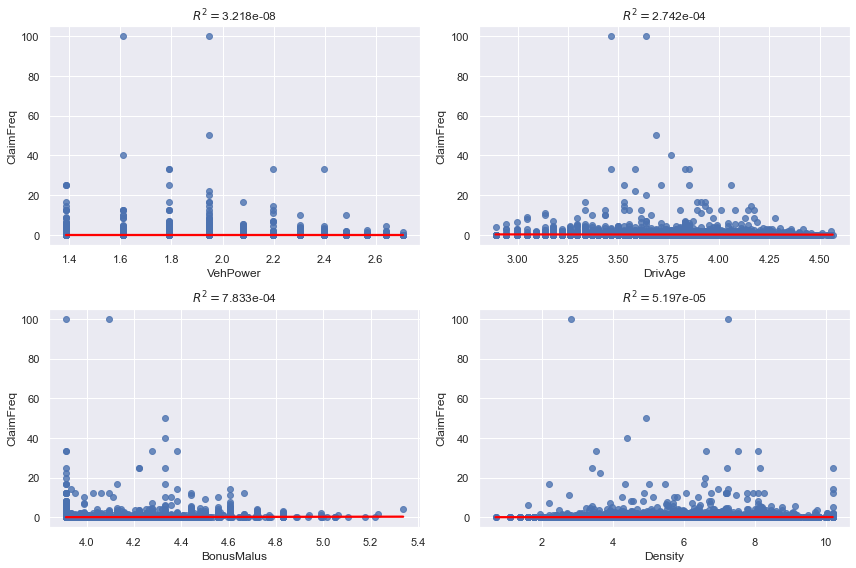

In [12]:
print("Continous features:")
cont_feats = data_all_df.iloc[:, :-3].select_dtypes(include="number").columns
fig, axes = plt.subplots(2, len(cont_feats) // 2, figsize=(12, 8))
y_name = "ClaimFreq"
for x_name, axis in tqdm(zip(cont_feats, axes.flatten()), total=len(cont_feats)):
    create_hist(data_all_df, x_name, y_name, axis)
fig.tight_layout()

Categorical features:


  0%|          | 0/4 [00:00<?, ?it/s]

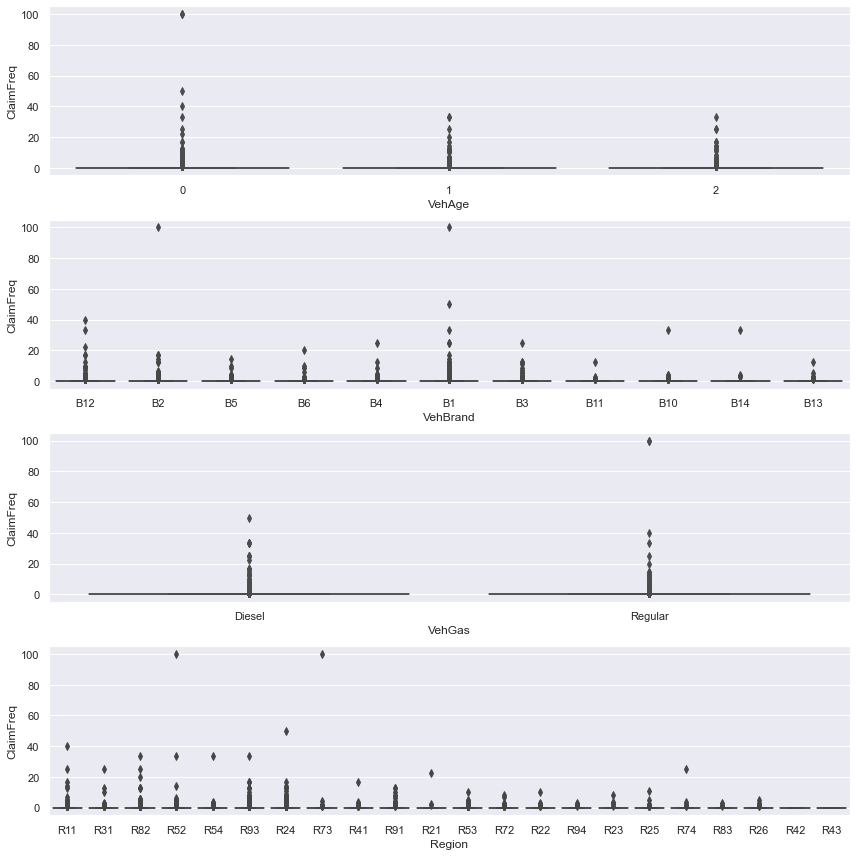

In [13]:
print("Categorical features:")
cate_feats = data_all_df.iloc[:, :-3].select_dtypes(exclude="number").columns
fig, axes = plt.subplots(len(cate_feats), 1, figsize=(12, 12))
y_name = "ClaimFreq"
for x_name, axis in tqdm(zip(cate_feats, axes.flatten()), total=len(cate_feats)):
    create_boxplot(data_all_df, x_name, y_name, axis)
fig.tight_layout()

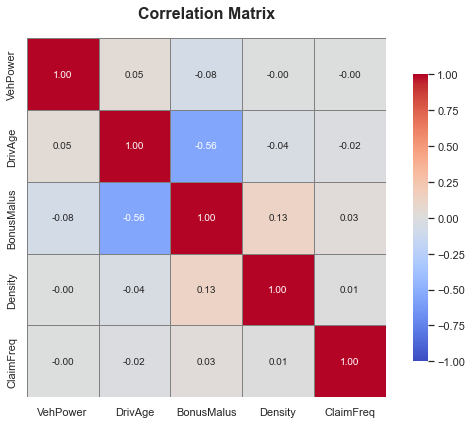

In [14]:
corr = data_all_df[list(cont_feats) + ["ClaimFreq"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    vmin=-1, vmax=1, 
    square=True, 
    cbar_kws={"shrink": 0.8}, 
    linewidths=0.5, 
    linecolor="gray",
)

plt.title("Correlation Matrix", fontsize=16, fontweight="bold", pad=20)
plt.tight_layout()

<span style="color: blue;"><b>Comments:</b></span>
- Low correlation between independent variables
- There is substantial amount of values close to zero in the dependent variable
- OLS can be highly biased
- Thus GLM like Poisson GLM and its deep-learning extension can be more suitable

### Question 1.b

In [15]:
# Train-test split
data_train_df, data_test_df = train_test_split(data_all_df, test_size=TEST_SIZE, random_state=SEED)
X_train, y_train = data_train_df.iloc[:, :-3], data_train_df.iloc[:, -3:]
X_test, y_test = data_test_df.iloc[:, :-3], data_test_df.iloc[:, -3:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((610206, 8), (610206, 3), (67801, 8), (67801, 3))

In [26]:
# Train Poisson GLM
# You can use sklearn.linear_model.Poisson_Regressor
model_pipeline = Pipeline(
    [
        ("preprocessor", create_preprocessing_steps(if_norm=True, if_one_hot=True)),
        ("model", PoissonRegressor(alpha=0.))
    ]
)
sample_weights = y_train["Exposure"]
model_pipeline.fit(X_train, y_train["ClaimFreq"], model__sample_weight=sample_weights)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('normalizer',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000216E1A68F40>),
                                                 ('one_hot_enc',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000216E1A78430>)])),
                ('model', PoissonRegressor(alpha=0.0))])

In [27]:
num_feats = model_pipeline.named_steps["preprocessor"].get_feature_names_out().shape
print(f"Number of features: {num_feats[0]}")

Number of features: 42


In [28]:
# Print MAE, MSE and loss on train and test data sets
metric_df = model_evaluation(
    model_pipeline, 
    X_train, y_train["Exposure"], y_train["ClaimFreq"],
    X_test, y_test["Exposure"], y_test["ClaimFreq"],
)
metric_df

,train,test
mean_absolute_error,0.464726,0.462678
mean_squared_error,0.342755,0.340618
mean_poisson_deviance,0.806320,0.800834


<span style="color: blue;"><b>Notes:</b></span>
- Mean Poisson deviance is weighted by "Exposure"

# Exercise 2 (Poisson FNN)

### Question 2.a

In [19]:
class InsuranceClaimDataModule(pl.LightningDataModule):
    def __init__(self, params: dict, *args):
        """
        params: batch_size, val_size, seed
        """
        super().__init__()
        self.params = params
        self.X_train, self.y_train, self.X_test, self.y_test = args
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            self.X_train, 
            self.y_train, 
            test_size=self.params["val_size"]
        )
        self.col_tfm = create_preprocessing_steps(if_norm=True, if_one_hot=True)

    def setup(self, stage: str = "fit"):
        if stage == "fit":
            X_train = self.col_tfm.fit_transform(self.X_train)
            self.train_ds = TensorDataset(torch.tensor(X_train.toarray()).float(), torch.tensor(self.y_train.values).float())
            X_val = self.col_tfm.transform(self.X_val)
            self.val_ds = TensorDataset(torch.tensor(X_val.toarray()).float(), torch.tensor(self.y_val.values).float())
        
        if stage in ["test", "predict"]:
            X_test = self.col_tfm.transform(self.X_test)
            self.test_ds = TensorDataset(torch.tensor(X_test.toarray()).float(), torch.tensor(self.y_test.values).float())
    
    def train_dataloader(self) -> DataLoader:
        data_loader = DataLoader(self.train_ds, batch_size=self.params["batch_size"], shuffle=True)
        return data_loader
    
    def val_dataloader(self) -> DataLoader:
        data_loader = DataLoader(self.val_ds, batch_size=self.params["batch_size"])
        return data_loader
    
    def test_dataloader(self) -> DataLoader:
        data_loader = DataLoader(self.test_ds, batch_size=self.params["batch_size"])
        return data_loader
    
    def predict_dataloader(self) -> DataLoader:
        data_loader = DataLoader(self.test_ds, batch_size=self.params["batch_size"])
        return data_loader


data_module_check = InsuranceClaimDataModule(NN_TRAIN_CONFIG, X_train, y_train, X_test, y_test)
data_module_check.setup("fit")
for X_iter, y_iter in data_module_check.train_dataloader():
    print(f"{X_iter.shape}, {y_iter.shape}")
    break

for X_iter, y_iter in data_module_check.val_dataloader():
    print(f"{X_iter.shape}, {y_iter.shape}")
    break

data_module_check.setup("test")
for X_iter, y_iter in data_module_check.test_dataloader():
    print(f"{X_iter.shape}, {y_iter.shape}")
    break

torch.Size([10000, 42]), torch.Size([10000, 3])
torch.Size([10000, 42]), torch.Size([10000, 3])
torch.Size([10000, 42]), torch.Size([10000, 3])


In [20]:
# Neural network implementation
class ResBlock(nn.Module):
    def __init__(self, hidden_units):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(hidden_units, hidden_units), nn.ReLU())
    
    def forward(self, x):
        x = self.net(x) + x
        
        return x
        

class MLP(nn.Module):
    def __init__(self, params: dict):
        """
        params: input_units, num_layers, hidden_units 
        """
        super().__init__()
        self.params = params
        self.use_norm = self.params.get("use_norm", False)
        
        layers = [
            nn.Linear(self.params["input_units"], self.params["hidden_units"]),
            nn.ReLU(),
        ]
        
        if self.use_norm:
            layers.append(nn.BatchNorm1d(self.params["hidden_units"]))
            
        for _ in range(self.params["num_layers"] - 2):  # Excluding input and output layers
            layers += [
                ResBlock(self.params["hidden_units"]),
            ]
            if self.use_norm:
                layers.append(nn.BatchNorm1d(self.params["hidden_units"]))
                
        self.out_layer = nn.Linear(self.params["hidden_units"], 1)
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        x_out = self.net(x)
        x_out = self.out_layer(x_out)
        x_out = torch.exp(x_out)
        
        return x_out.flatten()

    
def compute_weighted_poisson_deviance(y_pred, y_in, eps=1e-6):
    # y_pred: (B,), y: (B, 3)
    y = y_in[:, -1]
    weights = y_in[:, 0]
    weights /= weights.sum()
    loss = weights * 2 * (y_pred - y - y * torch.log(y_pred) + y * torch.log(y + eps))  # (B,)
    loss = loss.sum()
    
    return loss
    
    
data_module_check = InsuranceClaimDataModule(NN_TRAIN_CONFIG, X_train, y_train, X_test, y_test)
data_module_check.setup("fit")
for X_iter, y_iter in data_module_check.train_dataloader():
    print(f"{X_iter.shape}, {y_iter.shape}")
    break
mlp_params = {
    "input_units": X_iter.shape[1],
    "num_layers": 3,
    "hidden_units": 20,
}
model_check = MLP(mlp_params)
y_pred_check = model_check(X_iter)
print(f"y_pred: {y_pred_check.shape}")
loss_check = compute_weighted_poisson_deviance(y_pred_check, y_iter)
loss_check

torch.Size([10000, 42]), torch.Size([10000, 3])
y_pred: torch.Size([10000])


tensor(2.1582, grad_fn=<SumBackward0>)

In [21]:
class InsuranceClaimLModule(pl.LightningModule):
    def __init__(self, model: nn.Module, params: dict):
        """
        params: opt_cls, lr,
            scheduler_params: dict; keys: model_cls, params: dict 
        """
        super().__init__()
        self.model = model
        self.params = params
        self.train_metrics = MetricCollection(
            {
                "MAE": MeanAbsoluteError(),
                "MSE": MeanSquaredError(),
            },
            prefix="train_",
        )
        self.val_metrics = self.train_metrics.clone(prefix="val_")
    
    def forward(self, x_in):
        X, _ = x_in
        y_pred = self.model(X)
        
        return y_pred
    
    def predict_step(self, x_in):
        preds = self(x_in)
        return preds
    
    def training_step(self, batch, batch_idx):
        X, y = batch  # (B, num_feats), (B, 3)
        y_pred = self.model(X)
        loss = compute_weighted_poisson_deviance(y_pred, y)
        metrics_val = self.train_metrics(y_pred, y[:, -1])
        lr = self.trainer.optimizers[0].param_groups[0]["lr"]
        metrics_val["lr"] = lr
        
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log_dict(metrics_val, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
    
    def on_train_epoch_end(self):
        self.train_metrics.reset()
    
    def validation_step(self, batch, batch_idx):
        X, y = batch  # (B, num_feats), (B, 3) 
        y_pred = self.model(X)
        loss = compute_weighted_poisson_deviance(y_pred, y)
        self.val_metrics.update(y_pred, y[:, -1])
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
    
    def on_validation_epoch_end(self):
        self.log_dict(self.val_metrics.compute())
        self.val_metrics.reset()
    
    def configure_optimizers(self):
        opt = self.params["opt_cls"](self.model.parameters(), lr=self.params["lr"])
        scheduler_params = self.params["scheduler_params"]
        scheduler = scheduler_params["model_cls"](opt, **scheduler_params["params"])
        
        opt_config = {
            "optimizer": opt,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss",
                "interval": "epoch",
            },
        }
        
        return opt_config


def predict(trainer: pl.Trainer, pl_model: pl.LightningModule, data_module: pl.LightningDataModule):
    preds = trainer.predict(pl_model, data_module)
    preds = torch.cat(preds).cpu().numpy()
    
    return preds

### Question 2.b

In [22]:
# Train Poisson feedforward neural network model

# Print MAE, MSE and loss on train and test data sets

# Make sure your model outperforms the Poisson GLM model of Question 1.b.

# Exercise 3 (Tree-based methods)

### Question 3.a

In [23]:
# Implement a regression tree

# Cross-validation

# Print MAE, MSE and loss on train and test data sets

### Question 3.b

In [24]:
# Implement a random forest model

# Cross-validation

# Print MAE, MSE and loss on train and test data sets

### Question 3.c

In [25]:
# Implement gradient boosted trees

# Cross-validation

# Print MAE, MSE and loss on train and test data sets